# DeepKmeans

In [1]:
'''
Author: scikkk 203536673@qq.com
Date: 2022-06-25 12:56:02
LastEditors: scikkk
LastEditTime: 2023-01-25 22:21:08
Description: file content
'''
import h5py
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import LabelEncoder
from VAE import VAE

In [2]:
# for repeatability
torch.manual_seed(3407)

## Setup parameters

In [3]:

parser = argparse.ArgumentParser()
parser.add_argument('--n_neighbors', type=int, default=72)
parser.add_argument('--resolution', type=float, default=0.8)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--data_file', type=str, default='./data/sample_151673.h5')
parser.add_argument('--epoch_num', type=int, default=24)
parser.add_argument('--sigma', type=float, default=0.8)
parser.add_argument('--final_latent_file', type=str, default='final_latent_file.txt')
parser.add_argument('--predict_label_file', type=str, default='pred_labels.txt')
parser.add_argument('--device', type=str, default='cuda:0')

args = parser.parse_args(args=[])
print(args)

Namespace(batch_size=256, data_file='./data/sample_151673.h5', device='cuda:0', epoch_num=24, final_latent_file='final_latent_file.txt', n_neighbors=72, predict_label_file='pred_labels.txt', resolution=0.8, sigma=0.8)


## Load count data

In [4]:
# load data
data_mat = h5py.File(args.data_file)
x = np.array(data_mat['X'])
labels = np.array(data_mat['Y'])
data_mat.close()

# preprocess data
adata = sc.AnnData(x)
adata.obs['Group'] = labels
adata.obs['DCA_split'] = 'train'
adata.obs['DCA_split'] = adata.obs['DCA_split'].astype('category')
print('Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))

# normalize data
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_cells(adata, min_counts=1)
adata.raw = adata.copy()
sc.pp.normalize_per_cell(adata)
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
sc.pp.log1p(adata)
sc.pp.scale(adata)

print(adata.X.shape)
print(labels.shape)

D:\Temp\ipykernel_5500\2150884567.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(x)


Successfully preprocessed 3000 genes and 3639 cells.
(3639, 3000)
(3639,)


## Build VAE model

In [5]:
model = VAE(input_dim=adata.n_vars, z_dim=16, encodeLayer=[200], decodeLayer=[64,512], sigma=args.sigma, device=args.device)
print(str(model))

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=3000, out_features=200, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
  )
  (_enc_mu): Linear(in_features=200, out_features=16, bias=True)
  (_dec_mean): Sequential(
    (0): Linear(in_features=512, out_features=3000, bias=True)
    (1): MeanAct()
  )
  (_dec_disp): Sequential(
    (0): Linear(in_features=512, out_features=3000, bias=True)
    (1): DispAct()
  )
  (_dec_pi): Sequential(
    (0): Linear(in_features=512, out_features=3000, bias=True)
    (1): Sigmoid()
  )
  (zinb_loss): ZINBLoss()
)


## Training stage.

In [6]:
t0 = time()
losses = model.trainAE(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, 
                        batch_size=args.batch_size, epochs=args.epoch_num)

print(f'Training time: {int(time() - t0)}s.')


Train epoch   1, Loss: 1.18277216
Train epoch   2, Loss: 0.98199065
Train epoch   3, Loss: 0.95359620
Train epoch   4, Loss: 0.94215765
Train epoch   5, Loss: 0.93570331
Train epoch   6, Loss: 0.93228219
Train epoch   7, Loss: 0.92985026
Train epoch   8, Loss: 0.92844899
Train epoch   9, Loss: 0.92714067
Train epoch  10, Loss: 0.92563191
Train epoch  11, Loss: 0.92425506
Train epoch  12, Loss: 0.92316037
Train epoch  13, Loss: 0.92216224
Train epoch  14, Loss: 0.92144998
Train epoch  15, Loss: 0.92024349
Train epoch  16, Loss: 0.91953840
Train epoch  17, Loss: 0.91857634
Train epoch  18, Loss: 0.91777192
Train epoch  19, Loss: 0.91693845
Train epoch  20, Loss: 0.91624376
Train epoch  21, Loss: 0.91562804
Train epoch  22, Loss: 0.91510156
Train epoch  23, Loss: 0.91433736
Train epoch  24, Loss: 0.91389264
Training time: 7s.


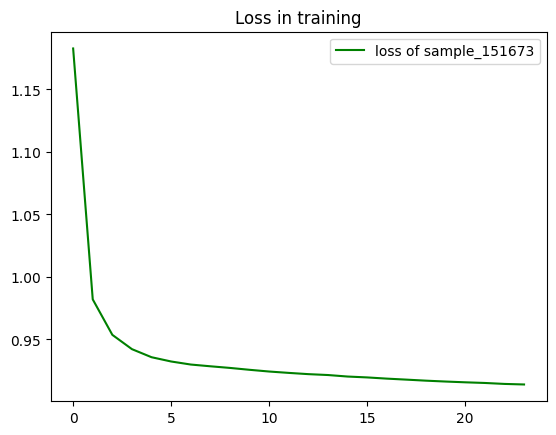

In [14]:

plt.plot(range(len(losses)),losses,'g', label=f'loss of sample_{args.data_file[-9:-3]}')
plt.title('Loss in training')
plt.legend()
plt.savefig(f'loss_sample_{args.data_file[-9:-3]}.png')

## Clustering stage

In [8]:
# estimate number of clusters by Louvain algorithm on the autoencoder latent representations
pretrain_latent = model.encodeBatch(torch.tensor(adata.X)).cpu().numpy()
adata_latent = sc.AnnData(pretrain_latent)
sc.pp.neighbors(adata_latent, n_neighbors=args.n_neighbors, use_rep="X")
sc.tl.louvain(adata_latent, resolution=args.resolution)
y_pred_init = np.asarray(adata_latent.obs['louvain'],dtype=int)
features = pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.n_obs))
Group = pd.Series(y_pred_init,index=np.arange(0,adata_latent.n_obs),name="Group")
Mergefeature = pd.concat([features,Group],axis=1)
cluster_centers = np.asarray(Mergefeature.groupby("Group").mean())
n_clusters = cluster_centers.shape[0]
print('Estimated number of cluster centers: ', n_clusters)
y_pred, _, _ = model.fit(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, n_clusters=n_clusters, init_centroid=cluster_centers, 
            y_pred_init=y_pred_init, y=labels)
print(f'Total time: {int(time() - t0)}s.')

Estimated number of cluster centers:  6
Clustering centers with k-means.
k-means: NMI= 0.6161, ARI= 0.5188
Total time: 16s.


## Save clustering result

In [9]:
final_latent = model.encodeBatch(torch.tensor(adata.X)).cpu().numpy()
np.savetxt(args.final_latent_file, final_latent, delimiter=",")
np.savetxt(args.predict_label_file, y_pred, delimiter=",", fmt="%i")
    

## Display clustering result

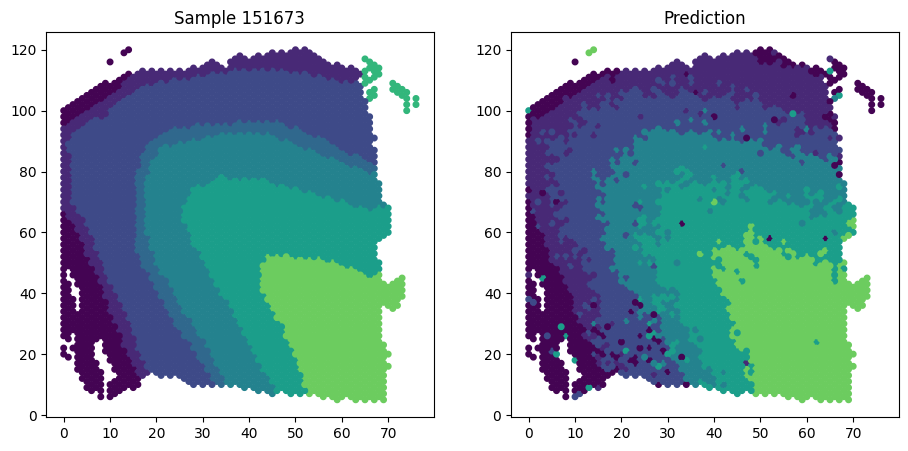

In [10]:
data_mat = h5py.File(args.data_file)
pos = np.array(data_mat['pos'])
true_label = np.array(data_mat['Y'])
data_mat.close()
encoder_x=LabelEncoder()
true_label=encoder_x.fit_transform(true_label)
pred_label = np.loadtxt('./pred_labels.txt').astype(int)
#colors = ['#440453', '#482976', '#3E4A88', '#30688D', '#24828E', '#1B9E8A', '#32B67B', '#6CCC5F', '#B4DD3D', '#FDE73A']
t_colors = ['#440453', '#482976', '#3E4A88', '#30688D', '#24828E', '#1B9E8A', '#32B67B', '#6CCC5F']
p_colors = ['#3E4A88', '#1B9E8A', '#24828E', '#6CCC5F', '#482976', '#440453', '#FDE73A','r','g','b']
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(pos[0], pos[1], c=list(map(lambda x: t_colors[x], true_label)),alpha = 1,marker='.',linewidths=2)
ax1.set_title(f'Sample {args.data_file[-9:-3]}')
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(pos[0], pos[1],c=list(map(lambda x: p_colors[x], pred_label)),alpha = 1,marker='.',linewidths=2)
ax2.set_title('Prediction')
plt.savefig(f'pred_{args.data_file[-9:-3]}.png')
plt.show()